# Predcition of Hospital Admission Related to Lower Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to lower respiratory tract infection (LRTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [184]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats as st
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [185]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [186]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [187]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 
                           'lrti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

In [188]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [189]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [190]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_lrti_admitted',
            event_col='event_lrti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_lrti_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [191]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    #save prob_pred_enc_lr_rf for analysis in r
    prob_pred_enc_lr_rf.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier()#n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #caculate ORs and intervals of LR model, save and print them 
    # lr_coef = pd.DataFrame({"or": lr.coef_})#, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef_exp = np.exp(lr_coef)
    # lr_coef_exp.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    # lr_coef = lr.coef_
    # print('LR ORs:\n %s'%(lr_coef))
    # lr_coef = pd.DataFrame(data=np.exp(lr.coef_), index=data_enc_dev_x.columns, columns=['lr_coef'])
    # lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    # lr_coef = pd.DataFrame(data=lr.coef_.T, index=data_enc_dev_x.columns, columns=['lr_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # # lr_coef['lr_coef_lower_bound'] = st.norm.ppf(lr_coef['lr_coef'])
    alpha = 0.1
    #the coefficients of the regression model
    coefs = np.r_[lr.coef_.T.tolist()]#[lr.intercept_], lr.coef_.T.tolist()
    #build an auxiliary dataframe with the constant term in it
    X_aux = data_enc_dev_x.copy()
    # X_aux.insert(0, 'const', 1)
    #degrees of freedom
    dof = -np.diff(X_aux.shape)[0]
    #Student's t-distribution table lookup
    t = stats.t.isf(alpha/2, dof)
    t_val = stats.norm.ppf(0.975)#1.96
    # #MSE of the residuals
    # mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
    #inverse of the variance of the parameters
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    #distance between lower and upper bound of CI
    # gap = t_val * np.sqrt(mse * var_params)
    gap = t_val * np.sqrt(var_params)
    lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
    lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('t value:%s'%(t))
    print('LR ORs:\n %s'%(lr_coef_ors_ints))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # rf_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [192]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    # #print summary of LR model
    # lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef = np.exp(lr_coef)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    # print('LR coefficients:\n %s'%(lr_coef))

    alpha = 0.1
    #the coefficients of the regression model
    coefs = np.r_[lr.coef_.T.tolist()] #[lr.intercept_], lr.coef_.T.tolist()
    #build an auxiliary dataframe with the constant term in it
    X_aux = data_enc_dev_x.copy()
   #  X_aux.insert(0, 'const', 1)
    #degrees of freedom
    dof = -np.diff(X_aux.shape)[0]
    #Student's t-distribution table lookup
    t = stats.t.isf(alpha/2, dof)
    t_val = stats.norm.ppf(0.975)#1.96
    # #MSE of the residuals
    # mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
    #inverse of the variance of the parameters
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    #distance between lower and upper bound of CI
    # gap = t_val * np.sqrt(mse * var_params)
    gap = t_val * np.sqrt(var_params)
    lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
    lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('t value:%s'%(t))
    print('LR ORs:\n %s'%(lr_coef_ors_ints))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [193]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):#, rf_pred_dev, rf_pred_val):
    # ##calibration for RF
    # rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    # #
    # rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    # #plot calibration plot for RF model with development and validation data
    # fig, ax1 = plt.subplots(figsize=(7, 7))
    # plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    # plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    # plt.xlabel('Mean predicted probabilities', fontsize=14)
    # plt.ylabel('Proportion of observed values', fontsize=14)
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=12, rotation=0)
    # plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    # plt.title("Calibration plot of RF model", fontsize=14)
    # legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    # legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    # plt.legend(handles=[legend_dev, legend_val])
    # plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    # plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [194]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')

In [195]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [196]:
#process 20 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)
data_lrti_13 = proc_infec_data(data,13)
data_lrti_14 = proc_infec_data(data,14)
data_lrti_15 = proc_infec_data(data,15)
data_lrti_16 = proc_infec_data(data,16)
data_lrti_17 = proc_infec_data(data,17)
data_lrti_18 = proc_infec_data(data,18)
data_lrti_19 = proc_infec_data(data,19)
data_lrti_20 = proc_infec_data(data,20)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12, data_lrti_13, data_lrti_14, data_lrti_15, data_lrti_16, data_lrti_17, data_lrti_18, data_lrti_19, data_lrti_20])
data_lrti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [197]:
##add variable season
#convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] 
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

In [198]:
#add variable time period
data_lrti.loc[(data_lrti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_lrti.loc[((data_lrti['date'] >= '2020-05') & (data_lrti['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_lrti.loc[(data_lrti['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

In [199]:
data_lrti['date'].max()

'2023-05'

#### event and duration

In [200]:
#scenario 1
#not hosped (nothing happened)
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0

In [201]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]

In [202]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [203]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30

#give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

In [204]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [205]:
#drop anybody with age less than 18 or 0!
data_lrti = data_lrti[~(data_lrti['age'] < 18)] 
data_lrti['age'][data_lrti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

In [206]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking": dict_smoking})

In [207]:
#drop rows with missing region
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
   data_lrti = data_lrti[data_lrti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_lrti.columns) and (data_lrti['smoking'].isnull().sum() > 0):
    data_lrti['smoking'] = data_lrti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

In [208]:
#missing values of bmi assign 5 and 0; categorise bmi
data_lrti['bmi_cat'] = 5

for idx, x in enumerate(data_lrti['bmi_cat']):
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 30:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 25) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 30):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 18.5) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 25):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 18.5:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

In [209]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])
#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [210]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})

In [211]:
data_lrti.ethnicity.value_counts('NA')

white      0.601105
unknown    0.248159
other      0.075621
asian      0.075115
Name: ethnicity, dtype: float64

In [212]:
data_lrti.smoking.value_counts('NA')

unknown         0.414305
smoker          0.391323
never_smoked    0.130261
ex_smoker       0.064111
Name: smoking_status, dtype: float64

In [213]:
data_lrti.bmi_cat.value_counts('NA')

obese             0.522319
unknown           0.251607
overweight        0.110592
healthy_weight    0.082872
underweight       0.032610
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [214]:
#categorise CCI
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

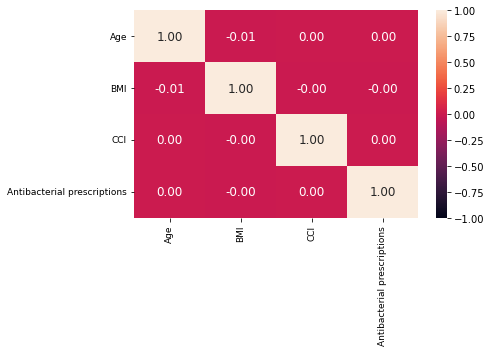

In [215]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [216]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date', 'period',
                                   'event_lrti_admitted', 'duration_lrti_admitted'
                                    ]]

In [217]:
#switch variable lrti_ab_date into a binary variable
data_lrti[['ab_binary']] = data_lrti[['lrti_ab_date']].where(data_lrti[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]

#no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti_incdt[data_lrti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti_incdt[data_lrti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti_prevl[data_lrti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti_prevl[data_lrti_prevl['ab_binary'] == 1]

In [218]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_lrti_incdt_prepandemic = data_lrti_incdt[data_lrti_incdt['period'] == 'prepandemic']
data_lrti_incdt_during_pandemic = data_lrti_incdt[(data_lrti_incdt['period'] == 'during_pandemic')]
data_lrti_incdt_post_2nd_lockdown = data_lrti_incdt[data_lrti_incdt['period'] == 'post_2nd_lockdown']
data_lrti_prevl_prepandemic = data_lrti_prevl[data_lrti_prevl['period'] == 'prepandemic']
data_lrti_prevl_during_pandemic = data_lrti_prevl[(data_lrti_prevl['period'] == 'during_pandemic')]
data_lrti_prevl_post_2nd_lockdown = data_lrti_prevl[data_lrti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_lrti_no_abs_incdt_prepandemic = data_lrti_incdt_prepandemic[data_lrti_incdt_prepandemic['ab_binary'] == 0]
data_lrti_no_abs_incdt_during_pandemic = data_lrti_incdt_during_pandemic[data_lrti_incdt_during_pandemic['ab_binary'] == 0]
data_lrti_no_abs_incdt_post_2nd_lockdown = data_lrti_incdt_post_2nd_lockdown[data_lrti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_lrti_no_abs_prevl_prepandemic = data_lrti_prevl_prepandemic[data_lrti_prevl_prepandemic['ab_binary'] == 0]
data_lrti_no_abs_prevl_during_pandemic = data_lrti_prevl_during_pandemic[data_lrti_prevl_during_pandemic['ab_binary'] == 0]
data_lrti_no_abs_prevl_post_2nd_lockdown = data_lrti_prevl_post_2nd_lockdown[data_lrti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [219]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [220]:
# #make summary tables
# make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)
# make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt)
# make_summary_table('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)
# make_summary_table('lrti', 'abs_prevl', data_lrti_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 111697 total observations, 111003 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 111697
number of events observed = 694
   partial log-likelihood = -8042.19
         time fit was run = 2023-08-01 17:37:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.00       1.00       0.11            -0.22             0.22                 0.80                 1.25
CCI_cat[T.medium]               -0.00       1.00       0.12            -0.24             0.24                 0.78                 1.27
CCI_cat[T.high]                 -0.17       0.84       0.16            -0.48             0.14                 0.62                 1.15
CCI_cat[T.very_high]             0.01       1.01       0.13            -0.24             0.27                 0.79                 1.31
age_cat[T.25_34]                 0.02       1.02       0.14            -0.26             0.29                 0.77                 1.34
age_cat[T.35_44]                 0.02       1.02       0.14            -0.26             0.29                 0.77                 1.34
age_cat[T.45_54]                 0.03       1.03       0.14            -0.25             0.30                 0.78                 1.36
age_cat[T.55_64]                -0.15       0.86       0.15            -0.44             0.14                 0.65                 1.14
age_cat[T.65_74]                -0.07       0.93       0.14            -0.35             0.21                 0.70                 1.23
age_cat[T.75_more]               0.00       1.00       0.14            -0.27             0.28                 0.76                 1.32
antibacterial_brit               0.02       1.02       0.03            -0.03             0.08                 0.97                 1.08
bmi_cat[T.obese]                 0.08       1.08       0.14            -0.20             0.36                 0.82                 1.43
bmi_cat[T.overweight]           -0.06       0.94       0.18            -0.41             0.29                 0.66                 1.34
bmi_cat[T.underweight]           0.19       1.21       0.23            -0.27             0.65                 0.76                 1.92
bmi_cat[T.unknown]              -0.04       0.96       0.15            -0.34             0.27                 0.71                 1.30
ethnicity[T.other]               0.10       1.10       0.21            -0.31             0.50                 0.74                 1.65
ethnicity[T.unknown]             0.23       1.26       0.17            -0.09             0.56                 0.91                 1.75
ethnicity[T.white]               0.14       1.16       0.16            -0.16             0.45                 0.85                 1.57
flu_vaccine[T.yes]               0.18       1.20       0.12            -0.05             0.42                 0.95                 1.52
imd[T.medium]                    0.08       1.09       0.12            -0.15             0.32                 0.86                 1.37
imd[T.unaffluent]                0.06       1.06       0.12            -0.18             0.29                 0.84                 1.34
imd[T.unknown]                  -0.17       0.84       0.20            -0.57             0.22                 0.57                 1.25
imd[T.very_affluent]            -0.24       0.78       0.13            -0.50             0.01                 0.61                 1.01
imd[T.very_unaffluent]          -0.07       0.93       0.12            -0.31             0.17                 0.73                 1.19
region[T.east_midlands]          0.10       1.11       0.16      

13043


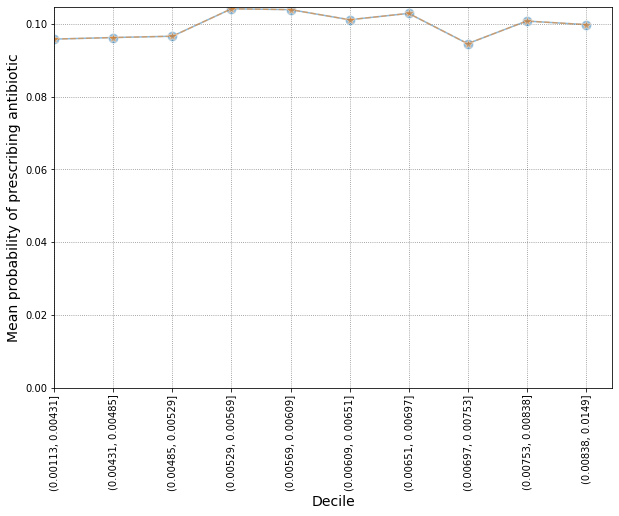


AUROC of LR for deciles with development and validation data: 0.51074 and 0.50794
t value:1.6448659104525827
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00431, 0.00485]  0.029593    0.012028    0.047159  1.030036   
bins_(0.00485, 0.00529]  0.014686   -0.002855    0.032227  1.014794   
bins_(0.00529, 0.00569]  0.096858    0.079201    0.114516  1.101704   
bins_(0.00569, 0.00609]  0.065692    0.048067    0.083317  1.067898   
bins_(0.00609, 0.00651]  0.072146    0.054574    0.089718  1.074812   
bins_(0.00651, 0.00697]  0.097657    0.080115    0.115198  1.102584   
bins_(0.00697, 0.00753] -0.020888   -0.038485   -0.003291  0.979329   
bins_(0.00753, 0.00838]  0.041860    0.024190    0.059530  1.042749   
bins_(0.00838, 0.0149]   0.038808    0.021176    0.056439  1.039570   

                         ors_lower  ors_upper  
bins_(0.00431, 0.00485]   1.012100   1.048289  
bins_(0.00485, 0.00529]   0.997149   1.032752  
bins_(0.00529, 0.00569]   

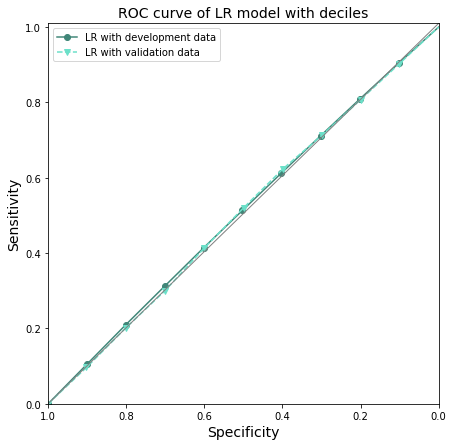

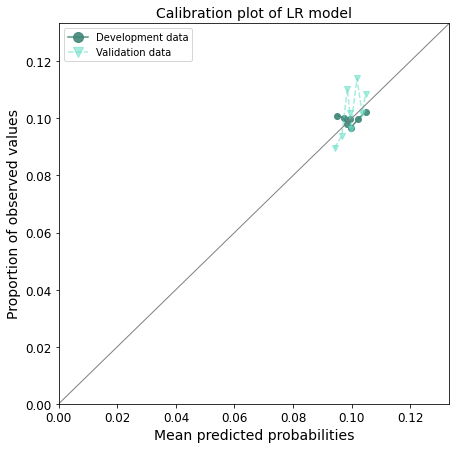


AUROC of LR for risk factors with development and validation data: 0.51599 and 0.50536
t value:1.6448659131267185
LR ORs:
                                  coef  coef_lower  coef_upper       ors  \
age_cat_25_34               -0.077223   -0.097454   -0.056992  0.925684   
age_cat_35_44               -0.021050   -0.041231   -0.000869  0.979170   
age_cat_45_54               -0.015914   -0.036112    0.004284  0.984212   
age_cat_55_64               -0.066006   -0.086156   -0.045855  0.936126   
age_cat_65_74               -0.039134   -0.059213   -0.019056  0.961621   
age_cat_75_more             -0.079957   -0.100125   -0.059789  0.923156   
sex_male                     0.007631   -0.003405    0.018667  1.007660   
CCI_cat_high                 0.035245    0.013631    0.056859  1.035873   
CCI_cat_low                  0.044296    0.028377    0.060216  1.045292   
CCI_cat_medium               0.047300    0.029523    0.065076  1.048436   
CCI_cat_very_high            0.061543    0.042857  

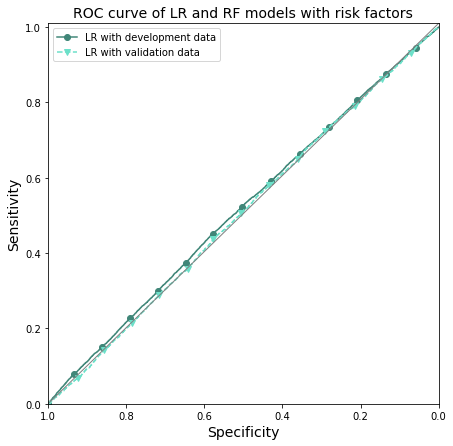

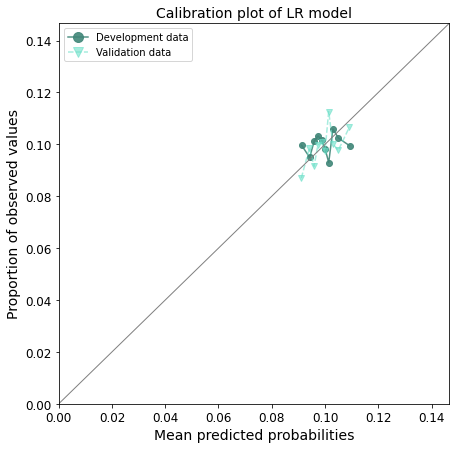

In [221]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_lrti_no_abs_incdt, prob_pred_lrti_no_abs_incdt_bin = cox_build('lrti', 'incdt', data_lrti_incdt, data_lrti_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_deciles('lrti', 'incdt_deciles', prob_pred_lrti_no_abs_incdt)
#calibration plots of rf and lr with deciles
calibration_rf_lr('lrti', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('lrti', 'incdt', prob_pred_enc_lr_rf_incdt)

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_riskfactors('lrti', 'incdt_riskfactors', prob_pred_lrti_no_abs_incdt)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('lrti', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

In [222]:
# alpha = 0.1
# #the coefficients of the regression model
# coefs = np.r_[lr.coef_.T.tolist()]#[lr.intercept_], lr.coef_.T.tolist()
# #build an auxiliary dataframe with the constant term in it
# X_aux = data_enc_dev_incdt_x.copy()
# # X_aux.insert(0, 'const', 1)
# #degrees of freedom
# dof = -np.diff(X_aux.shape)[0]
# print(dof)
# #Student's t-distribution table lookup
# # t = stats.t.isf(alpha/2, dof)
# t = stats.norm.ppf(0.975)
# t_val = 1.96
# # #MSE of the residuals
# # mse = np.sum((data_enc_dev_incdt_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_incdt_x)) ** 2) / dof
# # print(mse)
# #inverse of the variance of the parameters
# var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
# # var_params = np.linalg.inv(X_aux.T.dot(X_aux))
# print(var_params)
# # #distance between lower and upper bound of CI
# gap = t_val * np.sqrt(mse * var_params)
# gap
# # lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
# # lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
# # # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
# # # lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
# # print('t value:%s'%(t))
# # print('LR ORs:\n %s'%(lr_coef_ors_ints))

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12418 total observations, 12340 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12418
number of events observed = 78
   partial log-likelihood = -713.85
         time fit was run = 2023-08-01 17:37:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.52       1.69       0.38            -0.22             1.26                 0.81                 3.54
CCI_cat[T.medium]                0.60       1.81       0.40            -0.19             1.38                 0.82                 3.99
CCI_cat[T.high]                  0.05       1.05       0.53            -0.98             1.09                 0.37                 2.96
CCI_cat[T.very_high]             0.20       1.22       0.45            -0.68             1.08                 0.50                 2.95
age_cat[T.25_34]                 0.29       1.34       0.40            -0.50             1.08                 0.61                 2.95
age_cat[T.35_44]                 0.04       1.05       0.43            -0.79             0.88                 0.45                 2.42
age_cat[T.45_54]                -0.15       0.86       0.45            -1.03             0.73                 0.36                 2.08
age_cat[T.55_64]                -0.06       0.94       0.44            -0.92             0.80                 0.40                 2.21
age_cat[T.65_74]                 0.23       1.25       0.40            -0.57             1.02                 0.57                 2.76
age_cat[T.75_more]              -0.16       0.85       0.45            -1.05             0.72                 0.35                 2.06
antibacterial_brit               0.06       1.06       0.08            -0.09             0.22                 0.91                 1.24
bmi_cat[T.obese]                -0.09       0.91       0.44            -0.96             0.78                 0.38                 2.18
bmi_cat[T.overweight]            0.68       1.97       0.48            -0.26             1.62                 0.77                 5.04
bmi_cat[T.underweight]           0.72       2.06       0.61            -0.47             1.92                 0.63                 6.79
bmi_cat[T.unknown]              -0.13       0.87       0.48            -1.07             0.81                 0.34                 2.24
ethnicity[T.other]               0.21       1.23       0.61            -0.98             1.40                 0.37                 4.04
ethnicity[T.unknown]            -0.04       0.96       0.51            -1.04             0.97                 0.35                 2.64
ethnicity[T.white]               0.24       1.27       0.47            -0.68             1.16                 0.51                 3.19
flu_vaccine[T.yes]              -0.34       0.71       0.46            -1.25             0.57                 0.29                 1.77
imd[T.medium]                   -0.20       0.81       0.41            -1.01             0.60                 0.36                 1.82
imd[T.unaffluent]                0.50       1.64       0.35            -0.19             1.18                 0.83                 3.24
imd[T.unknown]                   0.37       1.45       0.53            -0.66             1.41                 0.52                 4.08
imd[T.very_affluent]             0.08       1.08       0.39            -0.68             0.84                 0.51                 2.31
imd[T.very_unaffluent]          -0.10       0.90       0.40            -0.89             0.68                 0.41                 1.98
region[T.east_midlands]          0.27       1.31       0.48           

13036


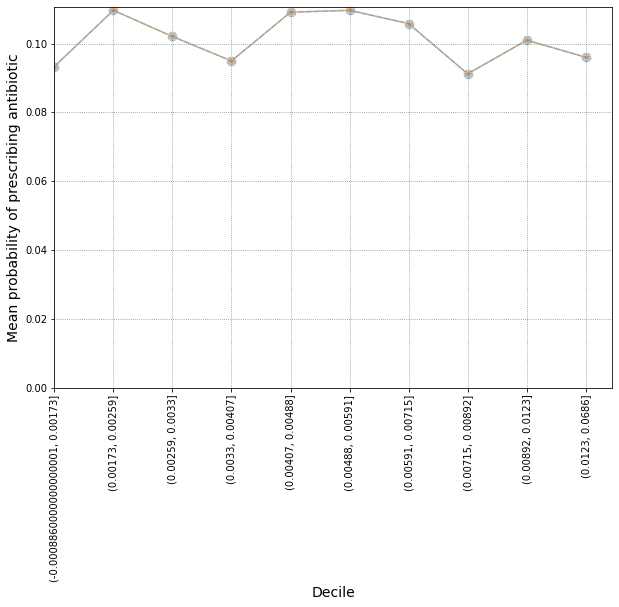


AUROC of LR for deciles with development and validation data: 0.52195 and 0.50385
t value:1.6449639804889422
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00173, 0.00259]  0.188483    0.135742    0.241225  1.207417   
bins_(0.00259, 0.0033]   0.024591   -0.028420    0.077602  1.024896   
bins_(0.0033, 0.00407]  -0.036829   -0.089192    0.015535  0.963841   
bins_(0.00407, 0.00488]  0.144699    0.091920    0.197479  1.155692   
bins_(0.00488, 0.00591]  0.192807    0.140312    0.245301  1.212648   
bins_(0.00591, 0.00715]  0.076123    0.023666    0.128580  1.079095   
bins_(0.00715, 0.00892]  0.056224    0.003464    0.108984  1.057835   
bins_(0.00892, 0.0123]   0.120587    0.067827    0.173348  1.128159   
bins_(0.0123, 0.0686]    0.025397   -0.027633    0.078428  1.025723   

                         ors_lower  ors_upper  
bins_(0.00173, 0.00259]   1.145386   1.272807  
bins_(0.00259, 0.0033]    0.971980   1.080692  
bins_(0.0033, 0.00407]    

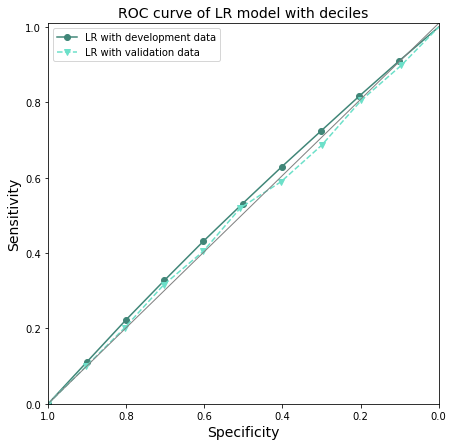

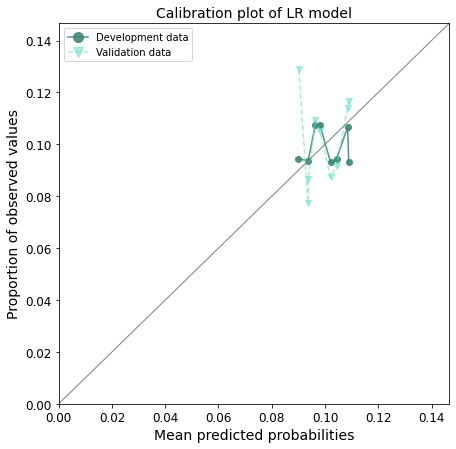


AUROC of LR for risk factors with development and validation data: 0.53491 and 0.49279
t value:1.6449641966946464
LR ORs:
                                  coef  coef_lower  coef_upper       ors  \
age_cat_25_34                0.097611    0.037223    0.157999  1.102534   
age_cat_35_44                0.104598    0.044314    0.164881  1.110264   
age_cat_45_54               -0.000513   -0.060807    0.059781  0.999487   
age_cat_55_64                0.097394    0.037189    0.157599  1.102295   
age_cat_65_74                0.181352    0.121867    0.240837  1.198837   
age_cat_75_more              0.124723    0.064005    0.185441  1.132834   
sex_male                    -0.043058   -0.076139   -0.009978  0.957856   
CCI_cat_high                -0.086831   -0.151149   -0.022513  0.916832   
CCI_cat_low                 -0.021198   -0.068934    0.026539  0.979025   
CCI_cat_medium               0.006758   -0.046608    0.060124  1.006781   
CCI_cat_very_high            0.039036   -0.017444  

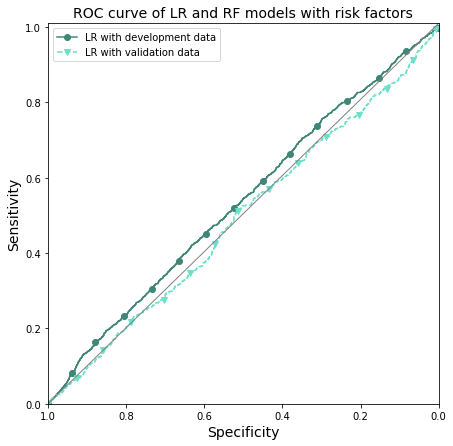

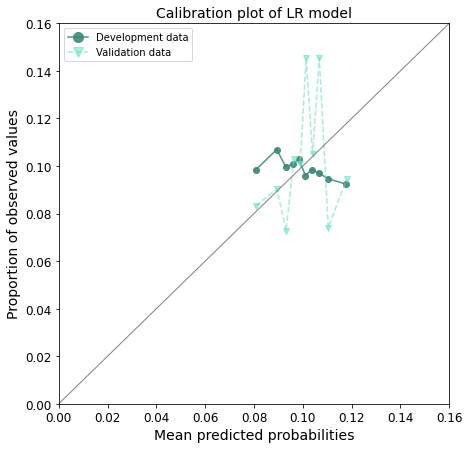

In [223]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_lrti_no_abs_prevl, prob_pred_lrti_no_abs_prevl_bin = cox_build('lrti', 'prevl', data_lrti_prevl, data_lrti_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_deciles('lrti', 'prevl_deciles', prob_pred_lrti_no_abs_prevl)
#calibration plots of rf and lr with deciles
calibration_rf_lr('lrti', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('lrti', 'prevl', prob_pred_enc_lr_rf_prevl)

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_riskfactors('lrti', 'prevl_riskfactors', prob_pred_lrti_no_abs_prevl)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('lrti', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28560 total observations, 28405 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 28560
number of events observed = 155
   partial log-likelihood = -1560.79
         time fit was run = 2023-08-01 17:37:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.23            -0.57             0.33                 0.56                 1.40
CCI_cat[T.medium]                0.02       1.02       0.25            -0.47             0.51                 0.63                 1.66
CCI_cat[T.high]                 -1.12       0.33       0.45            -2.00            -0.24                 0.14                 0.78
CCI_cat[T.very_high]             0.06       1.06       0.26            -0.44             0.57                 0.64                 1.77
age_cat[T.25_34]                 0.07       1.07       0.30            -0.51             0.66                 0.60                 1.93
age_cat[T.35_44]                -0.04       0.96       0.31            -0.64             0.56                 0.53                 1.75
age_cat[T.45_54]                 0.01       1.01       0.30            -0.58             0.60                 0.56                 1.83
age_cat[T.55_64]                -0.19       0.82       0.32            -0.82             0.43                 0.44                 1.54
age_cat[T.65_74]                -0.38       0.68       0.34            -1.04             0.28                 0.35                 1.32
age_cat[T.75_more]               0.47       1.60       0.27            -0.07             1.01                 0.93                 2.73
antibacterial_brit              -0.00       1.00       0.06            -0.11             0.11                 0.89                 1.11
bmi_cat[T.obese]                 0.01       1.01       0.29            -0.56             0.57                 0.57                 1.78
bmi_cat[T.overweight]           -0.09       0.91       0.37            -0.81             0.63                 0.44                 1.87
bmi_cat[T.underweight]           0.50       1.65       0.43            -0.34             1.34                 0.71                 3.81
bmi_cat[T.unknown]              -0.30       0.74       0.32            -0.94             0.33                 0.39                 1.39
ethnicity[T.other]               0.22       1.24       0.42            -0.61             1.04                 0.54                 2.83
ethnicity[T.unknown]             0.35       1.42       0.35            -0.33             1.03                 0.72                 2.80
ethnicity[T.white]              -0.00       1.00       0.34            -0.66             0.66                 0.52                 1.93
flu_vaccine[T.yes]               0.49       1.63       0.23             0.04             0.94                 1.04                 2.56
imd[T.medium]                   -0.13       0.88       0.23            -0.58             0.32                 0.56                 1.38
imd[T.unaffluent]               -0.43       0.65       0.25            -0.93             0.06                 0.40                 1.06
imd[T.unknown]                  -0.28       0.75       0.39            -1.04             0.48                 0.35                 1.61
imd[T.very_affluent]            -0.67       0.51       0.27            -1.20            -0.14                 0.30                 0.87
imd[T.very_unaffluent]          -0.52       0.60       0.26            -1.03            -0.01                 0.36                 0.99
region[T.east_midlands]         -0.08       0.92       0.40         

13048


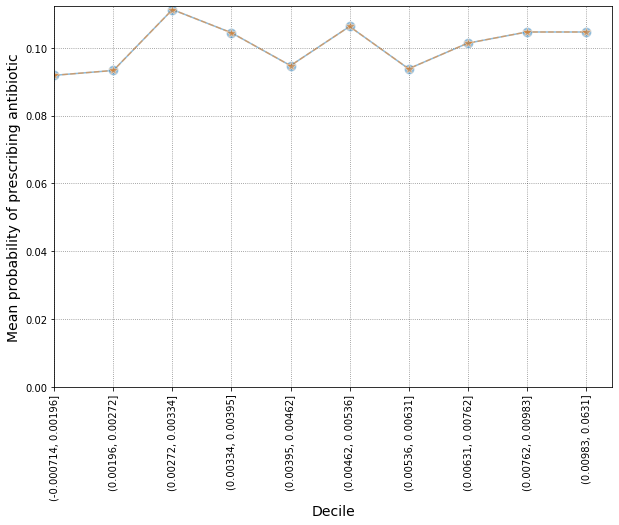


AUROC of LR for deciles with development and validation data: 0.52105 and 0.51295
t value:1.64490162713685
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00196, 0.00272]  0.021647   -0.013246    0.056541  1.021883   
bins_(0.00272, 0.00334]  0.244465    0.209477    0.279453  1.276938   
bins_(0.00334, 0.00395]  0.140114    0.105407    0.174821  1.150405   
bins_(0.00395, 0.00462]  0.091654    0.057050    0.126258  1.095986   
bins_(0.00462, 0.00536]  0.180378    0.145982    0.214774  1.197670   
bins_(0.00536, 0.00631]  0.112729    0.077623    0.147835  1.119329   
bins_(0.00631, 0.00762]  0.137787    0.102954    0.172620  1.147731   
bins_(0.00762, 0.00983]  0.184335    0.149622    0.219048  1.202419   
bins_(0.00983, 0.0631]   0.211022    0.176150    0.245893  1.234939   

                         ors_lower  ors_upper  
bins_(0.00196, 0.00272]   0.986841   1.058170  
bins_(0.00272, 0.00334]   1.233033   1.322407  
bins_(0.00334, 0.00395]   1.

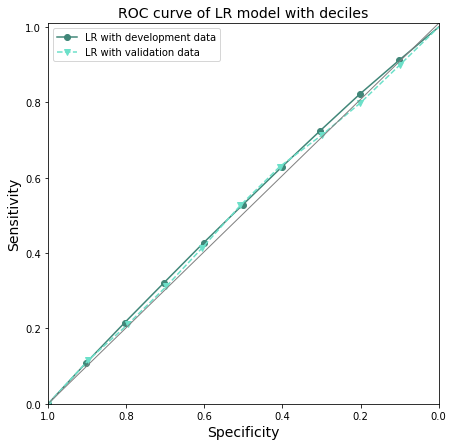

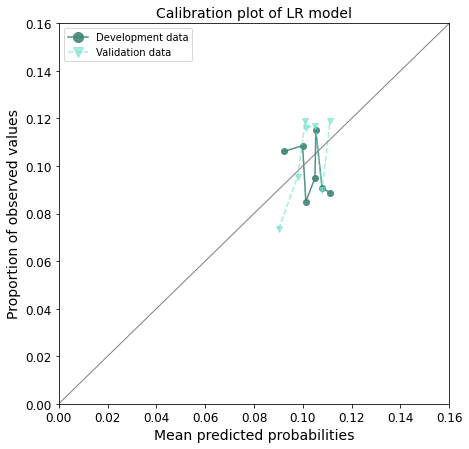

In [224]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_lrti_no_abs_incdt_prepandemic, prob_pred_lrti_no_abs_incdt_prepandemic_bin = cox_build('lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic, data_lrti_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('lrti', 'incdt_prepandemic_deciles', prob_pred_lrti_no_abs_incdt_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('lrti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)#, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26088 total observations, 25926 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 26088
number of events observed = 162
   partial log-likelihood = -1631.43
         time fit was run = 2023-08-01 17:37:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.34       0.71       0.24            -0.80             0.13                 0.45                 1.14
CCI_cat[T.medium]               -0.05       0.95       0.25            -0.54             0.45                 0.58                 1.56
CCI_cat[T.high]                  0.19       1.21       0.28            -0.36             0.75                 0.69                 2.11
CCI_cat[T.very_high]             0.01       1.01       0.26            -0.49             0.52                 0.61                 1.68
age_cat[T.25_34]                -0.21       0.81       0.28            -0.76             0.35                 0.47                 1.41
age_cat[T.35_44]                -0.31       0.73       0.29            -0.88             0.26                 0.42                 1.29
age_cat[T.45_54]                -0.39       0.68       0.29            -0.96             0.19                 0.38                 1.20
age_cat[T.55_64]                -0.58       0.56       0.31            -1.20             0.03                 0.30                 1.03
age_cat[T.65_74]                -0.06       0.94       0.27            -0.58             0.47                 0.56                 1.59
age_cat[T.75_more]              -0.11       0.90       0.27            -0.64             0.43                 0.53                 1.53
antibacterial_brit              -0.06       0.94       0.06            -0.17             0.05                 0.84                 1.06
bmi_cat[T.obese]                 0.41       1.51       0.35            -0.27             1.10                 0.76                 3.00
bmi_cat[T.overweight]            0.26       1.30       0.42            -0.55             1.08                 0.57                 2.95
bmi_cat[T.underweight]           0.51       1.66       0.53            -0.53             1.54                 0.59                 4.68
bmi_cat[T.unknown]               0.31       1.37       0.37            -0.41             1.04                 0.66                 2.82
ethnicity[T.other]               0.53       1.70       0.44            -0.34             1.40                 0.71                 4.06
ethnicity[T.unknown]             0.38       1.46       0.39            -0.38             1.14                 0.68                 3.12
ethnicity[T.white]               0.42       1.52       0.37            -0.30             1.14                 0.74                 3.13
flu_vaccine[T.yes]              -0.20       0.82       0.29            -0.77             0.36                 0.46                 1.44
imd[T.medium]                   -0.01       0.99       0.25            -0.49             0.47                 0.61                 1.61
imd[T.unaffluent]               -0.08       0.93       0.25            -0.57             0.42                 0.57                 1.52
imd[T.unknown]                  -0.32       0.73       0.44            -1.19             0.55                 0.30                 1.73
imd[T.very_affluent]            -0.12       0.88       0.25            -0.62             0.37                 0.54                 1.45
imd[T.very_unaffluent]          -0.06       0.94       0.25            -0.55             0.43                 0.58                 1.54
region[T.east_midlands]          0.34       1.40       0.34         

13046


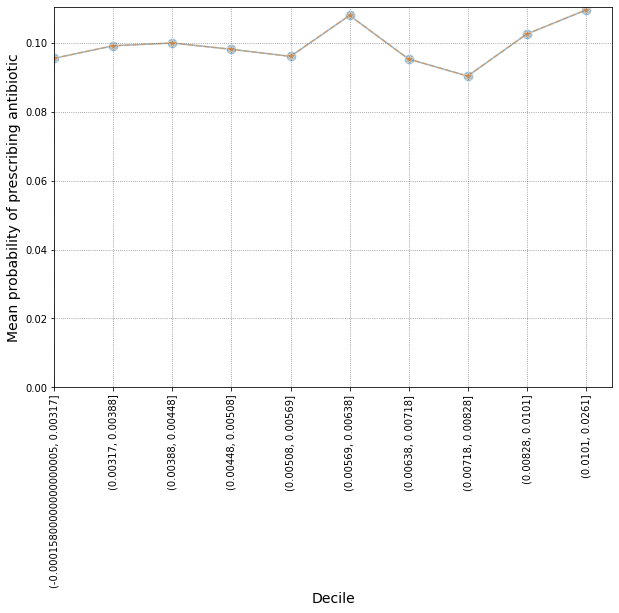


AUROC of LR for deciles with development and validation data: 0.51648 and 0.51787
t value:1.6449062449828575
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00317, 0.00388]  0.044543    0.008290    0.080795  1.045550   
bins_(0.00388, 0.00448]  0.061903    0.025176    0.098629  1.063859   
bins_(0.00448, 0.00508]  0.055202    0.018775    0.091629  1.056754   
bins_(0.00508, 0.00569] -0.011594   -0.047946    0.024757  0.988473   
bins_(0.00569, 0.00638]  0.152503    0.115981    0.189025  1.164746   
bins_(0.00638, 0.00718]  0.019145   -0.017194    0.055484  1.019330   
bins_(0.00718, 0.00828] -0.050370   -0.086481   -0.014260  0.950877   
bins_(0.00828, 0.0101]   0.077005    0.040591    0.113420  1.080048   
bins_(0.0101, 0.0261]    0.118894    0.082454    0.155333  1.126250   

                         ors_lower  ors_upper  
bins_(0.00317, 0.00388]   1.008325   1.084148  
bins_(0.00388, 0.00448]   1.025496   1.103657  
bins_(0.00448, 0.00508]   

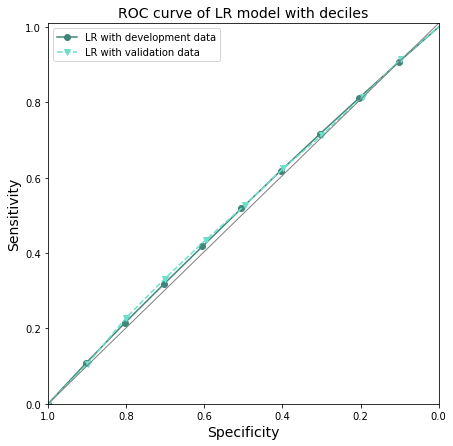

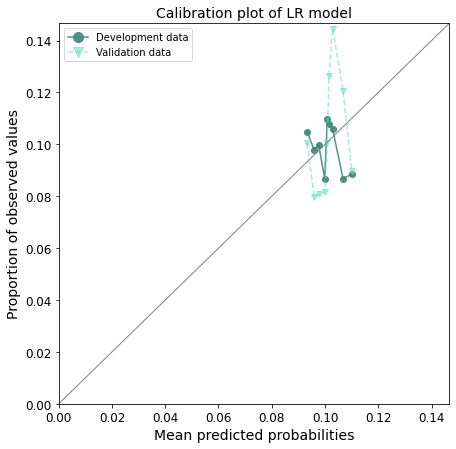

In [225]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_lrti_no_abs_incdt_during_pandemic, prob_pred_lrti_no_abs_incdt_during_pandemic_bin = cox_build('lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic, data_lrti_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('lrti', 'incdt_during_pandemic_deciles', prob_pred_lrti_no_abs_incdt_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('lrti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)#, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 47924 total observations, 47595 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 47924
number of events observed = 329
   partial log-likelihood = -3515.20
         time fit was run = 2023-08-01 17:37:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.17            -0.30             0.35                 0.74                 1.42
CCI_cat[T.medium]                0.16       1.18       0.18            -0.19             0.52                 0.83                 1.67
CCI_cat[T.high]                 -0.11       0.90       0.23            -0.57             0.35                 0.57                 1.42
CCI_cat[T.very_high]             0.11       1.12       0.19            -0.26             0.48                 0.77                 1.62
age_cat[T.25_34]                -0.10       0.90       0.20            -0.49             0.28                 0.61                 1.33
age_cat[T.35_44]                -0.12       0.89       0.20            -0.51             0.27                 0.60                 1.31
age_cat[T.45_54]                -0.11       0.90       0.20            -0.50             0.28                 0.61                 1.33
age_cat[T.55_64]                -0.31       0.73       0.21            -0.72             0.10                 0.49                 1.11
age_cat[T.65_74]                -0.14       0.87       0.20            -0.53             0.25                 0.59                 1.28
age_cat[T.75_more]              -0.26       0.77       0.21            -0.67             0.15                 0.51                 1.16
antibacterial_brit               0.08       1.08       0.04             0.00             0.15                 1.00                 1.16
bmi_cat[T.obese]                 0.10       1.10       0.21            -0.30             0.50                 0.74                 1.66
bmi_cat[T.overweight]           -0.06       0.94       0.26            -0.57             0.45                 0.57                 1.57
bmi_cat[T.underweight]           0.06       1.06       0.36            -0.64             0.76                 0.53                 2.14
bmi_cat[T.unknown]              -0.06       0.94       0.22            -0.50             0.38                 0.60                 1.46
ethnicity[T.other]              -0.06       0.94       0.27            -0.60             0.47                 0.55                 1.60
ethnicity[T.unknown]            -0.02       0.98       0.22            -0.45             0.41                 0.64                 1.50
ethnicity[T.white]              -0.14       0.87       0.20            -0.54             0.25                 0.58                 1.29
flu_vaccine[T.yes]               0.28       1.33       0.17            -0.04             0.61                 0.96                 1.84
imd[T.medium]                    0.26       1.30       0.19            -0.10             0.63                 0.90                 1.88
imd[T.unaffluent]                0.32       1.38       0.19            -0.04             0.68                 0.96                 1.98
imd[T.unknown]                  -0.07       0.93       0.32            -0.70             0.56                 0.49                 1.75
imd[T.very_affluent]             0.19       1.21       0.19            -0.18             0.57                 0.84                 1.76
imd[T.very_unaffluent]           0.31       1.36       0.19            -0.06             0.67                 0.94                 1.96
region[T.east_midlands]          0.05       1.05       0.24         

13053


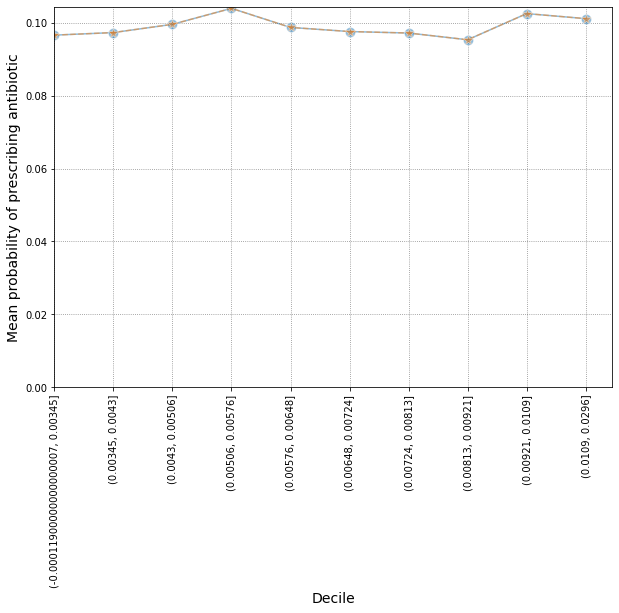


AUROC of LR for deciles with development and validation data: 0.50818 and 0.49978
t value:1.6448822810415085
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00345, 0.0043]   0.007312   -0.019633    0.034257  1.007339   
bins_(0.0043, 0.00506]   0.030589    0.003619    0.057560  1.031062   
bins_(0.00506, 0.00576]  0.063958    0.036985    0.090931  1.066048   
bins_(0.00576, 0.00648]  0.074871    0.047987    0.101756  1.077746   
bins_(0.00648, 0.00724]  0.049245    0.022351    0.076140  1.050478   
bins_(0.00724, 0.00813]  0.040687    0.013921    0.067453  1.041526   
bins_(0.00813, 0.00921] -0.014002   -0.040818    0.012814  0.986096   
bins_(0.00921, 0.0109]   0.065580    0.038612    0.092548  1.067778   
bins_(0.0109, 0.0296]    0.058453    0.031766    0.085139  1.060195   

                         ors_lower  ors_upper  
bins_(0.00345, 0.0043]    0.980559   1.034851  
bins_(0.0043, 0.00506]    1.003625   1.059249  
bins_(0.00506, 0.00576]   

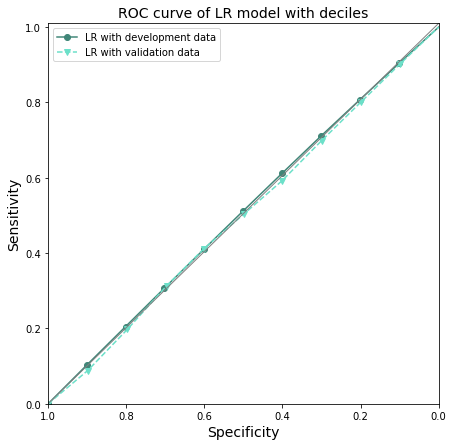

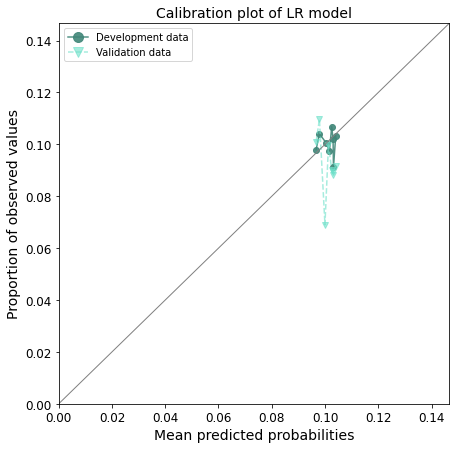

In [226]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_lrti_no_abs_incdt_post_2nd_lockdown, prob_pred_lrti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown, data_lrti_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('lrti', 'incdt_post_2nd_lockdown_deciles', prob_pred_lrti_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('lrti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)#, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3235 total observations, 3210 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3235
number of events observed = 25
   partial log-likelihood = -183.05
         time fit was run = 2023-08-01 17:37:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.35       1.42       0.53            -0.68             1.38                 0.51                 3.99
CCI_cat[T.medium]               -0.13       0.88       0.64            -1.38             1.12                 0.25                 3.08
CCI_cat[T.high]                 -1.16       0.31       1.10            -3.32             0.99                 0.04                 2.70
CCI_cat[T.very_high]           -18.18       0.00    3890.17         -7642.77          7606.42                 0.00                  inf
age_cat[T.25_34]                -0.87       0.42       0.84            -2.52             0.79                 0.08                 2.20
age_cat[T.35_44]                -1.64       0.19       1.10            -3.80             0.52                 0.02                 1.69
age_cat[T.45_54]                 0.23       1.25       0.62            -0.98             1.43                 0.37                 4.20
age_cat[T.55_64]                 0.04       1.04       0.64            -1.22             1.30                 0.29                 3.67
age_cat[T.65_74]                -0.50       0.61       0.74            -1.94             0.95                 0.14                 2.58
age_cat[T.75_more]              -0.55       0.58       0.74            -2.00             0.90                 0.13                 2.46
antibacterial_brit               0.11       1.12       0.14            -0.16             0.38                 0.85                 1.47
bmi_cat[T.obese]                -0.94       0.39       0.61            -2.13             0.25                 0.12                 1.28
bmi_cat[T.overweight]           -0.12       0.88       0.72            -1.53             1.28                 0.22                 3.60
bmi_cat[T.underweight]         -18.56       0.00    8256.55        -16201.10         16163.98                 0.00                  inf
bmi_cat[T.unknown]              -0.56       0.57       0.64            -1.81             0.69                 0.16                 2.00
ethnicity[T.other]              17.89   5.87e+07    5564.30        -10887.94         10923.72                 0.00                  inf
ethnicity[T.unknown]            17.88   5.80e+07    5564.30        -10887.95         10923.70                 0.00                  inf
ethnicity[T.white]              17.80   5.39e+07    5564.30        -10888.03         10923.63                 0.00                  inf
flu_vaccine[T.yes]              -0.76       0.47       1.03            -2.78             1.26                 0.06                 3.52
imd[T.medium]                    0.27       1.31       0.77            -1.24             1.79                 0.29                 5.96
imd[T.unaffluent]                0.70       2.01       0.71            -0.70             2.10                 0.50                 8.14
imd[T.unknown]                   0.29       1.33       1.17            -2.00             2.57                 0.14                13.11
imd[T.very_affluent]             0.72       2.06       0.72            -0.68             2.13                 0.51                 8.38
imd[T.very_unaffluent]           0.54       1.71       0.74            -0.91             1.99                 0.40                 7.28
region[T.east_midlands]          0.25       1.29       0.77            -1

13109


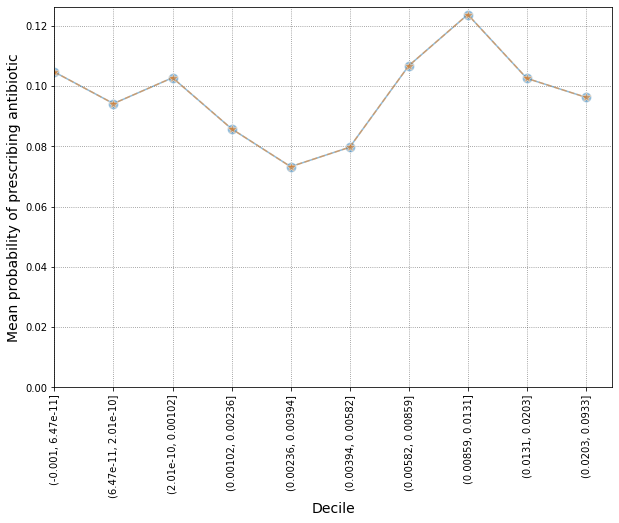


AUROC of LR for deciles with development and validation data: 0.54616 and 0.49759
t value:1.6452802059345475
LR ORs:
                                coef  coef_lower  coef_upper       ors  \
bins_(0.00102, 0.00236]   -0.014459   -0.119524    0.090606  0.985645   
bins_(0.00236, 0.00394]   -0.435099   -0.538255   -0.331943  0.647200   
bins_(0.00394, 0.00582]   -0.270456   -0.372488   -0.168425  0.763031   
bins_(0.00582, 0.00859]   -0.014443   -0.119508    0.090623  0.985661   
bins_(0.00859, 0.0131]     0.317697    0.212023    0.423371  1.373960   
bins_(0.0131, 0.0203]     -0.063288   -0.167458    0.040883  0.938674   
bins_(0.0203, 0.0933]     -0.044854   -0.149919    0.060211  0.956137   
bins_(2.01e-10, 0.00102]  -0.031040   -0.132523    0.070443  0.969437   
bins_(6.47e-11, 2.01e-10] -0.024514   -0.127670    0.078642  0.975784   

                           ors_lower  ors_upper  
bins_(0.00102, 0.00236]     0.887343   1.094838  
bins_(0.00236, 0.00394]     0.583766   0.717528  


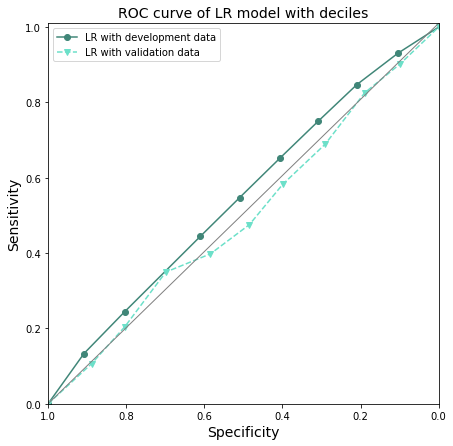

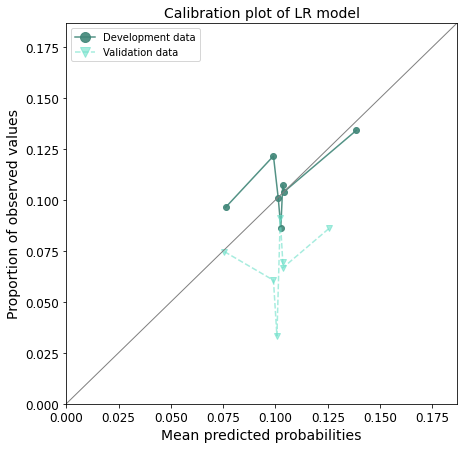

In [227]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_lrti_no_abs_prevl_prepandemic, prob_pred_lrti_no_abs_prevl_prepandemic_bin = cox_build('lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic, data_lrti_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('lrti', 'prevl_prepandemic_deciles', prob_pred_lrti_no_abs_prevl_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('lrti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)#, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2837 total observations, 2824 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 2837
number of events observed = 13
   partial log-likelihood = -87.36
         time fit was run = 2023-08-01 17:37:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.91       2.48       1.14            -1.32             3.14                 0.27                23.16
CCI_cat[T.medium]                1.70       5.50       1.10            -0.46             3.87                 0.63                47.72
CCI_cat[T.high]                  1.21       3.36       1.25            -1.23             3.66                 0.29                38.82
CCI_cat[T.very_high]           -17.20       0.00    5890.95        -11563.26         11528.86                 0.00                  inf
age_cat[T.25_34]                -0.47       0.63       1.45            -3.31             2.38                 0.04                10.79
age_cat[T.35_44]                -0.23       0.80       1.44            -3.04             2.59                 0.05                13.30
age_cat[T.45_54]                 0.52       1.67       1.25            -1.93             2.96                 0.15                19.24
age_cat[T.55_64]                 0.63       1.88       1.24            -1.80             3.06                 0.17                21.29
age_cat[T.65_74]                 0.77       2.17       1.18            -1.54             3.08                 0.22                21.80
age_cat[T.75_more]               1.20       3.30       1.17            -1.09             3.48                 0.33                32.62
antibacterial_brit               0.23       1.26       0.19            -0.15             0.60                 0.86                 1.83
bmi_cat[T.obese]                18.02   6.72e+07    8621.11        -16879.04         16915.08                 0.00                  inf
bmi_cat[T.overweight]           18.19   7.97e+07    8621.11        -16878.87         16915.25                 0.00                  inf
bmi_cat[T.underweight]          18.92   1.64e+08    8621.11        -16878.14         16915.98                 0.00                  inf
bmi_cat[T.unknown]              18.06   7.01e+07    8621.11        -16878.99         16915.12                 0.00                  inf
ethnicity[T.other]               0.53       1.69       1.25            -1.93             2.98                 0.14                19.75
ethnicity[T.unknown]            -0.73       0.48       1.44            -3.54             2.09                 0.03                 8.10
ethnicity[T.white]               0.27       1.32       1.07            -1.83             2.38                 0.16                10.80
flu_vaccine[T.yes]              -0.05       0.95       1.07            -2.15             2.04                 0.12                 7.73
imd[T.medium]                    0.82       2.28       1.24            -1.61             3.26                 0.20                26.01
imd[T.unaffluent]                0.68       1.98       1.24            -1.74             3.11                 0.18                22.37
imd[T.unknown]                   2.67      14.46       1.18             0.35             4.99                 1.42               146.79
imd[T.very_affluent]             1.11       3.02       1.17            -1.18             3.40                 0.31                29.84
imd[T.very_unaffluent]           0.97       2.63       1.24            -1.47             3.40                 0.23                29.83
region[T.east_midlands]          0.31       1.37       1.43            -2.

13169


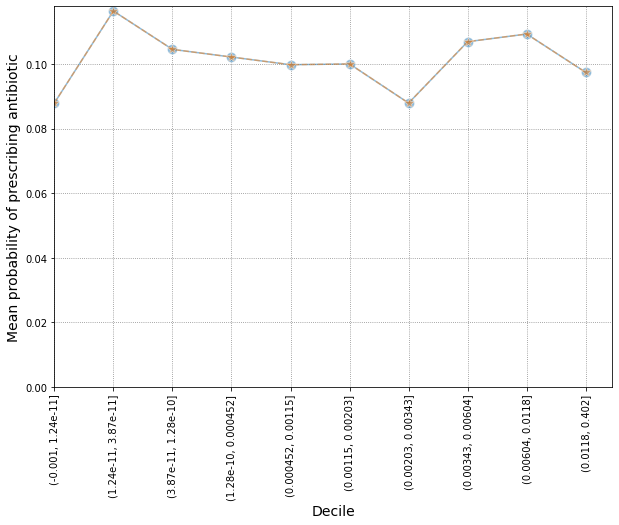


AUROC of LR for deciles with development and validation data: 0.54101 and 0.46425
t value:1.6453379677632722
LR ORs:
                                coef  coef_lower  coef_upper       ors  \
bins_(0.000452, 0.00115]   0.078394   -0.029992    0.186781  1.081549   
bins_(0.00115, 0.00203]    0.030240   -0.081258    0.141739  1.030702   
bins_(0.00203, 0.00343]   -0.029525   -0.137912    0.078861  0.970906   
bins_(0.00343, 0.00604]    0.058010   -0.054960    0.170981  1.059726   
bins_(0.00604, 0.0118]     0.311282    0.200850    0.421713  1.365174   
bins_(0.0118, 0.402]       0.260491    0.149530    0.371452  1.297567   
bins_(1.24e-11, 3.87e-11]  0.398553    0.285205    0.511901  1.489667   
bins_(1.28e-10, 0.000452]  0.009884   -0.100547    0.120316  1.009933   
bins_(3.87e-11, 1.28e-10]  0.030382   -0.079183    0.139948  1.030849   

                           ors_lower  ors_upper  
bins_(0.000452, 0.00115]    0.970453   1.205363  
bins_(0.00115, 0.00203]     0.921956   1.152276  


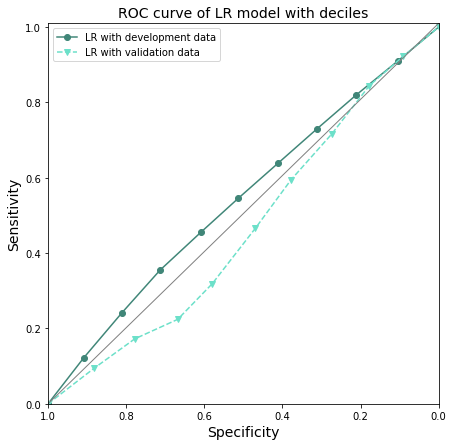

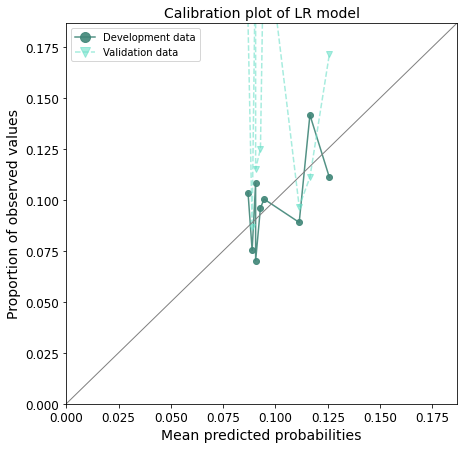

In [228]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_lrti_no_abs_prevl_during_pandemic, prob_pred_lrti_no_abs_prevl_during_pandemic_bin = cox_build('lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic, data_lrti_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('lrti', 'prevl_during_pandemic_deciles', prob_pred_lrti_no_abs_prevl_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('lrti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)#, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5348 total observations, 5305 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 5348
number of events observed = 43
   partial log-likelihood = -346.31
         time fit was run = 2023-08-01 17:38:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.46            -0.91             0.88                 0.40                 2.41
CCI_cat[T.medium]               -0.07       0.93       0.51            -1.07             0.92                 0.34                 2.51
CCI_cat[T.high]                 -0.88       0.41       0.80            -2.46             0.69                 0.09                 2.00
CCI_cat[T.very_high]             0.20       1.22       0.51            -0.80             1.20                 0.45                 3.31
age_cat[T.25_34]                 0.98       2.65       0.59            -0.19             2.14                 0.83                 8.51
age_cat[T.35_44]                 0.91       2.49       0.60            -0.27             2.10                 0.76                 8.15
age_cat[T.45_54]                -0.23       0.79       0.77            -1.74             1.27                 0.18                 3.56
age_cat[T.55_64]                 0.43       1.54       0.65            -0.84             1.71                 0.43                 5.50
age_cat[T.65_74]                 0.46       1.58       0.65            -0.81             1.73                 0.44                 5.64
age_cat[T.75_more]               0.26       1.30       0.67            -1.06             1.58                 0.35                 4.87
antibacterial_brit               0.04       1.05       0.11            -0.16             0.25                 0.85                 1.29
bmi_cat[T.obese]                 1.21       3.37       1.02            -0.79             3.22                 0.45                25.11
bmi_cat[T.overweight]            1.83       6.22       1.06            -0.24             3.90                 0.79                49.22
bmi_cat[T.underweight]           2.75      15.59       1.10             0.59             4.90                 1.80               134.72
bmi_cat[T.unknown]               0.87       2.40       1.07            -1.22             2.97                 0.29                19.54
ethnicity[T.other]               0.79       2.21       0.87            -0.92             2.50                 0.40                12.21
ethnicity[T.unknown]             0.83       2.30       0.77            -0.68             2.34                 0.51                10.37
ethnicity[T.white]               0.63       1.87       0.74            -0.82             2.08                 0.44                 7.99
flu_vaccine[T.yes]              -0.06       0.94       0.53            -1.10             0.97                 0.33                 2.65
imd[T.medium]                   -0.71       0.49       0.51            -1.70             0.28                 0.18                 1.32
imd[T.unaffluent]               -0.63       0.53       0.48            -1.57             0.31                 0.21                 1.37
imd[T.unknown]                 -18.25       0.00    5203.54        -10217.00         10180.50                 0.00                  inf
imd[T.very_affluent]            -0.42       0.65       0.44            -1.29             0.45                 0.27                 1.56
imd[T.very_unaffluent]          -0.33       0.72       0.44            -1.20             0.54                 0.30                 1.72
region[T.east_midlands]         -0.38       0.69       0.65            -1

13095


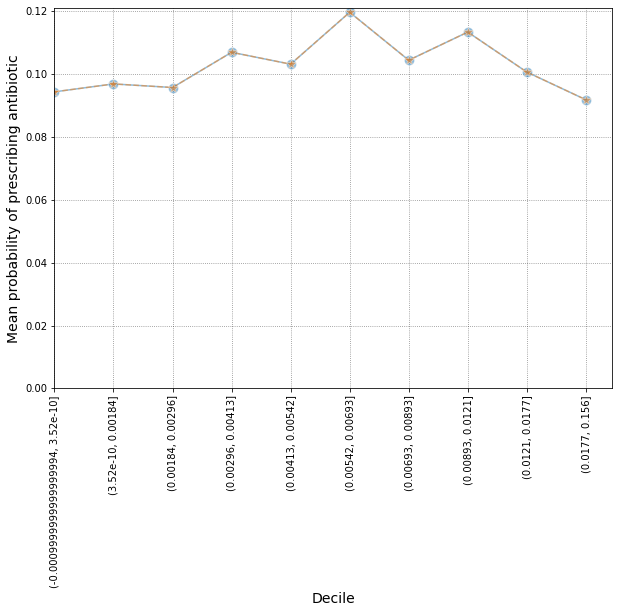


AUROC of LR for deciles with development and validation data: 0.53244 and 0.48875
t value:1.6451097196795523
LR ORs:
                               coef  coef_lower  coef_upper       ors  \
bins_(0.00184, 0.00296]  -0.102075   -0.182834   -0.021316  0.902962   
bins_(0.00296, 0.00413]   0.161361    0.081678    0.241045  1.175110   
bins_(0.00413, 0.00542]   0.208231    0.126848    0.289614  1.231498   
bins_(0.00542, 0.00693]   0.233893    0.154988    0.312798  1.263509   
bins_(0.00693, 0.00893]   0.025324   -0.055094    0.105743  1.025648   
bins_(0.00893, 0.0121]    0.212282    0.133055    0.291509  1.236496   
bins_(0.0121, 0.0177]     0.100877    0.020323    0.181431  1.106140   
bins_(0.0177, 0.156]     -0.059224   -0.141607    0.023160  0.942496   
bins_(3.52e-10, 0.00184]  0.086255    0.007477    0.165032  1.090084   

                          ors_lower  ors_upper  
bins_(0.00184, 0.00296]    0.832906   0.978909  
bins_(0.00296, 0.00413]    1.085106   1.272579  
bins_(0.00413

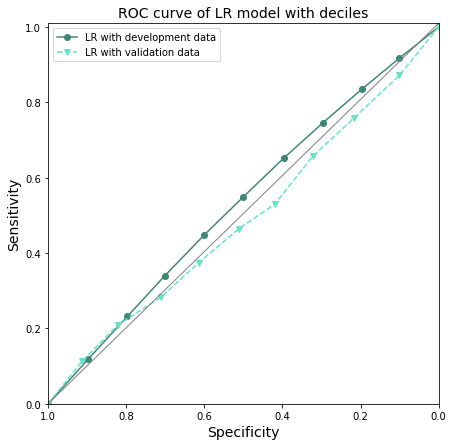

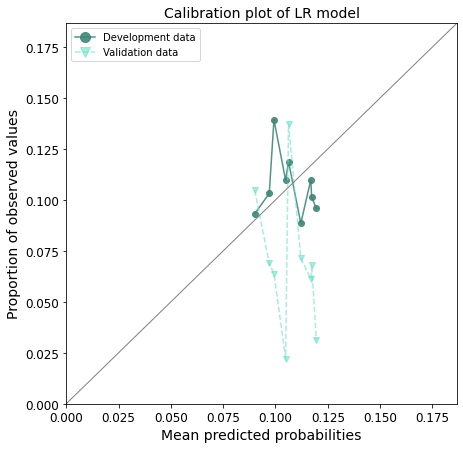

In [229]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_lrti_no_abs_prevl_post_2nd_lockdown, prob_pred_lrti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown, data_lrti_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('lrti', 'prevl_post_2nd_lockdown_deciles', prob_pred_lrti_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('lrti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)#, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")